# Imports and Simulation Parameters

In [1]:
import numpy as np
import math
import cmath
import scipy 
import scipy.integrate
import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

hbar = 1.0 / (2.0 * np.pi)

ZERO_TOLERANCE = 10**-6

/Users/joseph/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
MAX_VIBRATIONAL_STATES = 200

STARTING_GROUND_STATES = 5
STARTING_EXCITED_STATES = 5


time_scale_set = 10  #will divide the highest energy to give us the time step
low_frequency_cycles = 25.0 #will multiply the frequency of the lowest frequency mode to get the max time

In [3]:
#See if a factorial_Storage dictionary exists already and if not, create one
try:
    a = factorial_storage
except:
    factorial_storage = {}

# Defining Parameters of the System

In [4]:
energy_g = 0
energy_gamma = .1

energy_e = 0
energy_epsilon = .31


Huang_Rhys_Parameter = .80
S = Huang_Rhys_Parameter

#bookkeeping
overlap_storage = {}
electronic_energy_gap = energy_e + .5*energy_epsilon - (energy_g  + .5 * energy_gamma)
min_energy = energy_g + energy_gamma * .5


In [5]:
mu_0 = 1.0

If we set the central frequency of a pulse at the 0->0 transition, and we decide we care about the ratio of the 0->1 transition to the 0->0 transition and set that to be $\tau$ then the desired pulse width will be
\begin{align}
    \sigma &= \sqrt{-\frac{2 \ln (\tau)}{\omega_{\epsilon}^2}}
\end{align}

In [6]:
def blank_wavefunction(number_ground_states, number_excited_states):
    return np.zeros((number_ground_states + number_excited_states))

def perturbing_function(time):
#     stdev = 30000.0 * dt #very specific to 0->0 transition!
    stdev = 3000.0 * dt #clearly has a small amount of amplitude on 0->1 transition
    center = 6 * stdev
    return np.cos(electronic_energy_gap*(time - center) / hbar)*np.exp( - (time - center)**2 / (2 * stdev**2)) / stdev

def time_function_handle_from_tau(tau_proportion):
    stdev = np.sqrt( -2.0 * np.log(tau_proportion) / (energy_epsilon/hbar)**2)
    center = 6 * stdev
    return center, stdev, lambda t: np.cos(electronic_energy_gap*(t - center) / hbar)*np.exp( - (t - center)**2 / (2 * stdev**2)) / stdev


def time_function_handle_from_tau_and_kappa(tau_proportion, kappa_proportion):
    stdev = np.sqrt( -2.0 * np.log(tau_proportion) / (energy_epsilon/hbar)**2)
    center = 6 * stdev
    return center, stdev, lambda t: kappa_proportion * energy_gamma * np.cos(electronic_energy_gap*(t - center) / hbar)*np.exp( - (t - center)**2 / (2 * stdev**2)) / stdev


def perturbing_function_define_tau(time, tau_proportion):
    center, stdev, f = time_function_handle_from_tau(tau_proportion)
    return f(time)

# Defining Useful functions

$ O_{m}^{n} = \left(-1\right)^{n} \sqrt{\frac{e^{-S}S^{m+n}}{m!n!}} \sum_{j=0}^{\min \left( m,n \right)} \frac{m!n!}{j!(m-j)!(n-j)!}(-1)^j S^{-j} $

In [7]:
def factorial(i):
    if i in factorial_storage:
        return factorial_storage[i]
    if i <= 1:
        return 1.0
    else:
        out =  factorial(i - 1) * i
        factorial_storage[i] = out
        return out

def ndarray_factorial(i_array):
    return np.array([factorial(i) for i in i_array])    

In [8]:
def overlap_function(ground_quantum_number, excited_quantum_number):
    m = ground_quantum_number
    n = excited_quantum_number
    if (m,n) in overlap_storage:
        return overlap_storage[(m,n)]
    output = (-1)**n
    output *= math.sqrt(math.exp(-S) * S**(m + n) /(factorial(m) * factorial(n)) )
    j_indeces = np.array(range(0, min(m,n) + 1))
    j_summation = factorial(m) * factorial(n) * np.power(-1.0, j_indeces) * np.power(S, -j_indeces) 
    j_summation = j_summation / (ndarray_factorial(j_indeces) * ndarray_factorial( m - j_indeces) * ndarray_factorial(n - j_indeces) )
    output *= np.sum(j_summation)
    overlap_storage[(m,n)] = output
    return output  

# Solving the Differential Equation

\begin{align*}
	\left(\frac{d G_a(t)}{dt} + \frac{i}{\hbar}\Omega_{(a)}\right) &=-E(t)\frac{i}{\hbar}  \sum_{b} E_b(t) \mu_{a}^{b}\\
	\left(\frac{d E_b(t)}{dt} + \frac{i}{\hbar} \Omega^{(b)} \right) &=-E(t)\frac{i}{\hbar} \sum_{a} G_a(t) \mu_{a}^{b}
\end{align*}
Or in a more compact form:
\begin{align*}
	\frac{d}{dt}\begin{bmatrix}
		G_a(t) \\
		E_b(t)
	\end{bmatrix}
	= -\frac{i}{\hbar}
	\begin{bmatrix}
		\Omega_{(a)} & E(t) \mu_{a}^{b} \\
		E(t) \mu_{a}^{b} & \Omega^{b}
	\end{bmatrix}
	\cdot
	\begin{bmatrix}
		G_a(t) \\
		E_b(t)
	\end{bmatrix}
\end{align*}

In [9]:
def ode_diagonal_matrix(number_ground_states, number_excited_states):
    #Define the Matrix on the RHS of the above equation
    ODE_DIAGONAL_MATRIX = np.zeros((number_ground_states + number_excited_states, number_ground_states + number_excited_states), dtype=np.complex)
    #set the diagonals
    for ground_i in range(number_ground_states):
        ODE_DIAGONAL_MATRIX[ground_i, ground_i] = -1.0j * (energy_g + energy_gamma * (ground_i + .5)) / hbar

    for excited_i in range(number_excited_states):
        excited_index = excited_i + number_ground_states #the offset since the excited states comes later
        ODE_DIAGONAL_MATRIX[excited_index, excited_index] = -1.0j * (energy_e + energy_epsilon * (excited_i + .5)) / hbar
    
    return ODE_DIAGONAL_MATRIX

#now for the off-diagonals
def mu_matrix(c, number_ground_states, number_excited_states):
    MU_MATRIX = np.zeros((number_ground_states, number_excited_states), dtype = np.complex)
    for ground_a in range(number_ground_states):
        for excited_b in range(number_excited_states):
            new_mu_entry = overlap_function(ground_a, excited_b)
            if ground_a >0:
                new_mu_entry += c * math.sqrt(ground_a) * overlap_function(ground_a - 1, excited_b)
            
            new_mu_entry += c * math.sqrt(ground_a+1) * overlap_function(ground_a + 1, excited_b)
                
            MU_MATRIX[ground_a, excited_b] = new_mu_entry
    return MU_MATRIX

def ode_off_diagonal_matrix(c_value, number_ground_states, number_excited_states):
    output  = np.zeros((number_ground_states + number_excited_states, number_ground_states + number_excited_states), dtype=np.complex)
    MU_MATRIX = mu_matrix(c_value, number_ground_states, number_excited_states)
    output[0:number_ground_states, number_ground_states:] = -1.0j * mu_0 * MU_MATRIX  / hbar
    output[number_ground_states:, 0:number_ground_states] = -1.0j * mu_0 * MU_MATRIX.T  / hbar
    return output

def IR_transition_dipoles(number_ground_states, number_excited_states):
    "outputs matrices to calculate ground and excited state IR emission spectra.  Can be combined for total"
    output_g = np.zeros((number_ground_states + number_excited_states, number_ground_states + number_excited_states), dtype=np.complex)
    output_e = np.zeros((number_ground_states + number_excited_states, number_ground_states + number_excited_states), dtype=np.complex)
    
    for ground_a in range(number_ground_states):
        try:
            output_g[ground_a, ground_a + 1] = math.sqrt(ground_a + 1)
            output_g[ground_a + 1, ground_a] = math.sqrt(ground_a + 1)
        except:
            pass
        
        try:
            output_g[ground_a, ground_a - 1] = math.sqrt(ground_a)
            output_g[ground_a - 1, ground_a] = math.sqrt(ground_a)
        except:
            pass
    
    for excited_a in range(number_excited_states):
        matrix_index_e = number_ground_states + excited_a -1 #because of how 'number_ground_states' is defined
        try:
            output_e[matrix_index_e, matrix_index_e + 1] = math.sqrt(excited_a + 1)
            output_e[matrix_index_e + 1, matrix_index_e] = math.sqrt(excited_a + 1)
        except:
            pass
        
        try:
            output_e[matrix_index_e, matrix_index_e - 1] = math.sqrt(excited_a)
            output_e[matrix_index_e - 1, matrix_index_e] = math.sqrt(excited_a)
        except:
            pass
    
    return output_g, output_e

\begin{align*}
	\mu(x) &= \mu_0 \left(1 + \lambda x \right) \\
	&= \mu_0 \left(1 + c\left(a + a^{\dagger} \right) \right) \\
	\mu_{a}^{b} &= \mu_0\left(O_{a}^{b}  + c\left(\sqrt{a}O_{a-1}^{b} + \sqrt{a+1}O_{a+1}^{b}\right) \right)
\end{align*}

In [10]:
class VibrationalStateOverFlowException(Exception):
    def __init__(self):
        pass

In [11]:
def propagate_amplitude_to_end_of_perturbation(c_value, ratio_01_00, kappa=1, starting_ground_states=STARTING_GROUND_STATES, starting_excited_states=STARTING_EXCITED_STATES):
    center_time, stdev, time_function = time_function_handle_from_tau_and_kappa(ratio_01_00, kappa)
    ending_time = center_time + 8.0 * stdev
    
    number_ground_states = starting_ground_states
    number_excited_states = starting_excited_states
    
    while number_excited_states + number_ground_states < MAX_VIBRATIONAL_STATES:
        
        #define time scales
        max_energy = energy_e + energy_epsilon * (.5 + number_excited_states) + kappa * energy_gamma * mu_0
        dt = 1.0 / (time_scale_set *  max_energy)
        
        ODE_DIAGONAL = ode_diagonal_matrix(number_ground_states, number_excited_states) 
        ODE_OFF_DIAGONAL = ode_off_diagonal_matrix(c_value, number_ground_states, number_excited_states)
        
        def ODE_integrable_function(time, coefficient_vector):
            ODE_TOTAL_MATRIX = ODE_OFF_DIAGONAL * time_function(time) + ODE_DIAGONAL 
            return np.dot(ODE_TOTAL_MATRIX, coefficient_vector)
        
        #define the starting wavefuntion
        initial_conditions = blank_wavefunction(number_ground_states, number_excited_states)
        initial_conditions[0] = 1
        
        #create ode solver
        current_time = 0.0
        ode_solver = scipy.integrate.complex_ode(ODE_integrable_function)
        ode_solver.set_initial_value(initial_conditions, current_time)
        
        #Run it
        results = []
        try:  #this block catches an overflow into the highest ground or excited vibrational state
            while current_time < ending_time:
#                 print(current_time, ZERO_TOLERANCE)
                #update time, perform solution
                current_time = ode_solver.t+dt
                new_result = ode_solver.integrate(current_time)
                results.append(new_result)
                #make sure solver was successful
                if not ode_solver.successful():
                    raise Exception("ODE Solve Failed!")
                #make sure that there hasn't been substantial leakage to the highest excited states
                re_start_calculation = False
                if abs(new_result[number_ground_states - 1])**2 >= ZERO_TOLERANCE:
                    number_ground_states +=1
#                     print("Increasing Number of Ground vibrational states to %i " % number_ground_states)
                    re_start_calculation = True
                if abs(new_result[-1])**2 >= ZERO_TOLERANCE:
                    number_excited_states +=1
#                     print("Increasing Number of excited vibrational states to %i " % number_excited_states)
                    re_start_calculation = True
                if re_start_calculation:
                    raise VibrationalStateOverFlowException()
        except VibrationalStateOverFlowException:
            #Move on and re-start the calculation
            continue

        #Finish calculating
        results = np.array(results)
        return results, number_ground_states, number_excited_states
    raise Exception("NEEDED TOO MANY VIBRATIONAL STATES!  RE-RUN WITH DIFFERENT PARAMETERS!")

In [12]:
def get_average_quantum_number_time_series(c_value, ratio_01_00, kappa=1, starting_ground_states=STARTING_GROUND_STATES, starting_excited_states=STARTING_EXCITED_STATES):
    results, number_ground_states, number_excited_states = propagate_amplitude_to_end_of_perturbation(c_value, ratio_01_00, kappa, starting_ground_states, starting_excited_states)
    probabilities = np.abs(results)**2
    #calculate the average_vibrational_quantum_number series
    average_ground_quantum_number = probabilities[:,0:number_ground_states].dot(np.array(range(number_ground_states)) )
    average_excited_quantum_number = probabilities[:,number_ground_states:].dot(np.array(range(number_excited_states)))
    return average_ground_quantum_number, average_excited_quantum_number, results, number_ground_states, number_excited_states

In [13]:
def IR_emission_spectrum_after_excitation(c_value, ratio_01_00, kappa=1, starting_ground_states=STARTING_GROUND_STATES, starting_excited_states=STARTING_EXCITED_STATES):
    center_time, stdev, time_function = time_function_handle_from_tau_and_kappa(ratio_01_00, kappa)
    
    perturbation_ending_time = center_time + 8.0 * stdev
    simulation_ending_time = perturbation_ending_time + low_frequency_cycles * hbar/min_energy
    
    number_ground_states = starting_ground_states
    number_excited_states = starting_excited_states
    
    while number_excited_states + number_ground_states < MAX_VIBRATIONAL_STATES:
        
        ir_transDipole_g, ir_transDipole_e = IR_transition_dipoles(number_ground_states, number_excited_states)
        
        time_emission_g = [0]
        time_emission_e = [0]
        
        #define time scales
        e = energy_e + energy_epsilon * (.5 + number_excited_states)
        g = energy_g + energy_gamma* (.5 + number_ground_states)
        plus = e + g
        minus = e - g
        J = kappa * energy_gamma * mu_0
        max_split_energy = plus + math.sqrt(minus**2 + 4 * J**2)
        max_energy = max_split_energy * .5
        dt = 1.0 / (time_scale_set *  max_energy)
        
        time_values = np.arange(0, simulation_ending_time, dt)
        
        
        ODE_DIAGONAL = ode_diagonal_matrix(number_ground_states, number_excited_states) 
        ODE_OFF_DIAGONAL = ode_off_diagonal_matrix(c_value, number_ground_states, number_excited_states)
        
        def ODE_integrable_function(time, coefficient_vector):
            ODE_TOTAL_MATRIX = ODE_OFF_DIAGONAL * time_function(time) + ODE_DIAGONAL 
            return np.dot(ODE_TOTAL_MATRIX, coefficient_vector)
        
        def ODE_jacobean(time, coefficient_vector):
            ODE_TOTAL_MATRIX = ODE_OFF_DIAGONAL * time_function(time) + ODE_DIAGONAL 
            return ODE_TOTAL_MATRIX
        
        #define the starting wavefuntion
        initial_conditions = blank_wavefunction(number_ground_states, number_excited_states)
        initial_conditions[0] = 1
        
        #create ode solver
        current_time = 0.0
        try:
            del ode_solver
        except:
            pass
#         ode_solver = scipy.integrate.complex_ode(ODE_integrable_function)
        ode_solver = scipy.integrate.complex_ode(ODE_integrable_function, jac = ODE_jacobean)
#         ode_solver.set_integrator("lsoda")
        ode_solver.set_integrator("vode", with_jacobian=True)
        
        ode_solver.set_initial_value(initial_conditions, current_time)
        
        #Run it
        results = []
        try:  #this block catches an overflow into the highest ground or excited vibrational state
            while current_time < simulation_ending_time:
#                 print(current_time, ZERO_TOLERANCE)
                #update time, perform solution
                current_time = ode_solver.t+dt
                new_result = ode_solver.integrate(current_time)
                results.append(new_result)
                #make sure solver was successful
                if not ode_solver.successful():
                    raise Exception("ODE Solve Failed!")
                
                if current_time < perturbation_ending_time:
                    #make sure that there hasn't been substantial leakage to the highest excited states
                    re_start_calculation = False
                    if abs(new_result[number_ground_states - 1])**2 >= ZERO_TOLERANCE:
                        number_ground_states +=1
#                         print("Increasing Number of Ground vibrational states to %i " % number_ground_states)
                        re_start_calculation = True
                    if abs(new_result[-1])**2 >= ZERO_TOLERANCE:
                        number_excited_states +=1
#                         print("Increasing Number of excited vibrational states to %i " % number_excited_states)
                        re_start_calculation = True
                    if re_start_calculation:
                        raise VibrationalStateOverFlowException()
                #calculate IR emission
                time_emission_g.append(np.conj(new_result).T.dot(ir_transDipole_g.dot(new_result)))
                time_emission_e.append(np.conj(new_result).T.dot(ir_transDipole_e.dot(new_result)))
                #on to next time value...
                
        except VibrationalStateOverFlowException:
            #Move on and re-start the calculation
            continue

        #Finish calculating
        results = np.array(results)
        n_t = len(time_emission_e)
         
        time_emission_g = np.array(time_emission_g)
        time_emission_e = np.array(time_emission_e)
        
        filter_x = np.array(range(n_t))
        filter_center = n_t / 2.0
        filter_sigma = n_t / 10.0
        filter_values = np.exp(-(filter_x - filter_center)**2 / (2 * filter_sigma**2))
        
        frequencies = np.fft.fftshift(np.fft.fftfreq(time_emission_g.shape[0], d= dt))
        frequency_emission_g = dt * np.fft.fftshift(np.fft.fft(time_emission_g * filter_values))
        frequency_emission_e = dt * np.fft.fftshift(np.fft.fft(time_emission_e * filter_values))
        
        return results, frequencies, frequency_emission_g, frequency_emission_e, number_ground_states, number_excited_states
    raise Exception("NEEDED TOO MANY VIBRATIONAL STATES!  RE-RUN WITH DIFFERENT PARAMETERS!")

In [14]:
c_values = np.logspace(-4, np.log10(1), 5)
tau_values = np.logspace(-4, np.log10(.95), 10)
kappa_values = np.logspace(-2, np.log10(5), 20)

number_calcs = c_values.shape[0] * tau_values.shape[0] * kappa_values.shape[0]

heating_results_ground = np.zeros((kappa_values.shape[0],  tau_values.shape[0], c_values.shape[0]))
ir_amplitudes = np.zeros(heating_results_ground.shape)
heating_results_excited = np.zeros(heating_results_ground.shape)

# Keep track of the IR Spectrum

n_g = STARTING_GROUND_STATES
n_e = STARTING_EXCITED_STATES

counter = 1
# we will use the value of c as a bellweather for how many starting states to work with.
c_to_ng = {}
c_to_ne = {}
for i_kappa, kappa in enumerate(kappa_values):
    # as we increase in both tau and 
    for i_tau, tau in enumerate(tau_values):
        
        for i_c, c in enumerate(c_values): 
            try:
                n_g = c_to_ng[c]
                n_e = c_to_ne[c]
            except:
                n_g = STARTING_GROUND_STATES
                n_e = STARTING_EXCITED_STATES
                c_to_ng[c] = n_g
                c_to_ne[c] = n_e
            
            
            
            sys.stdout.flush()
            sys.stdout.write("\r%i / %i Calculating kappa=%f, c=%f, tau=%f at n_g = %i and n_e=%i..." %(counter, number_calcs, kappa, c, tau, n_g, n_e))
#             print("\r%i / %i Calculating kappa=%f, c=%f, tau=%f at n_g = %i and n_e=%i..." %(counter, number_calcs, kappa, c, tau, n_g, n_e))
#             n_bar_g, n_bar_e, results, num_g, num_e = get_average_quantum_number_time_series(c,
#                                                                                          tau, 
#                                                                                          kappa,
#                                                                                          starting_ground_states = n_g, 
#                                                                                          starting_excited_states = n_e) 
            
#             heating_results_ground[i_kappa, i_tau, i_c] = n_bar_g[-1]
#             heating_results_excited[i_kappa, i_tau, i_c] = n_bar_e[-1]
            
            
            _, frequencies, emission_g, emission_e, num_g, num_e = IR_emission_spectrum_after_excitation(c,
                                                                                         tau, 
                                                                                         kappa,
                                                                                         starting_ground_states = n_g, 
                                                                                         starting_excited_states = n_e)
            if num_g > c_to_ng[c]:
                c_to_ng[c] = num_g
            if num_e > c_to_ne[c]:
                c_to_ne[c] = num_e
            vibrational_frequency_index = np.argmin(np.abs(energy_gamma - frequencies))
            ir_power = np.abs(emission_g[vibrational_frequency_index])**2
            ir_amplitudes[i_kappa, i_tau, i_c] = ir_power
            counter +=1
#             plt.figure()
#             plt.title(r"$\kappa{}, \tau={}, c={}".format(kappa, tau, c))
#             plt.plot(frequencies, emission_g)
#             plt.xlim(0, 2)


1000 / 1000 Calculating kappa=5.000000, c=1.000000, tau=0.950000 at n_g = 67 and n_e=52...

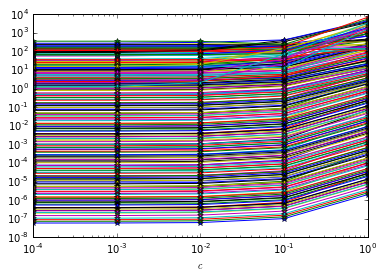

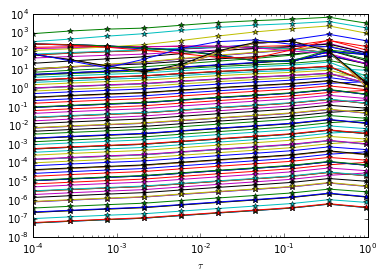

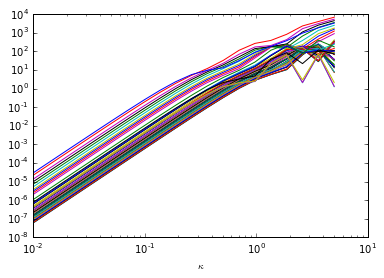

In [15]:
# decreased dt, does that keep these parameters from failing? last one is 600 / 800 Calculating kappa=8.858668, c=0.750000, tau=0.850000
for i_kappa, kappa in enumerate(kappa_values):
    for i_tau, tau in enumerate(tau_values):
        ir_power = ir_amplitudes[i_kappa, i_tau, :]
        plt.loglog(c_values, ir_power, "*-")
plt.xlabel(r"$c$")
plt.figure()
for i_kappa, kappa in enumerate(kappa_values):
    for i_c, c in enumerate(c_values):
        ir_power = ir_amplitudes[i_kappa, :, i_c]
        plt.loglog(tau_values, ir_power, "*-")
plt.xlabel(r"$\tau$")
plt.figure()
for i_tau, tau in enumerate(tau_values):
    for i_c, c in enumerate(c_values):
#     for i_c in [0,-1]:
        ir_power = ir_amplitudes[:, i_tau, i_c]
#         plt.loglog(kappa_values, ir_power, ["blue", "red"][i_c])
        plt.loglog(kappa_values, ir_power)
plt.xlabel(r"$\kappa$")
# plt.xlim(-.1, 1.1)
# plt.ylim(-10, 500)

In [16]:
c_log = np.log10(c_values)
tau_log = np.log10(tau_values)
kappa_log = np.log10(kappa_values)
log_ir_amplitudes = np.log(ir_amplitudes)
num_levels = 100
contours = np.linspace(np.min(log_ir_amplitudes), np.max(log_ir_amplitudes), num_levels)

IndexError: index 5 is out of bounds for axis 2 with size 5

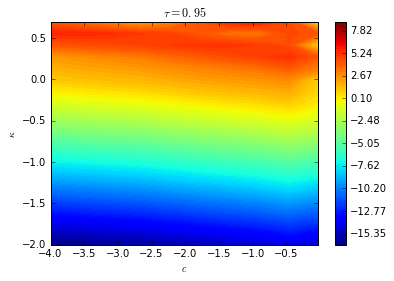

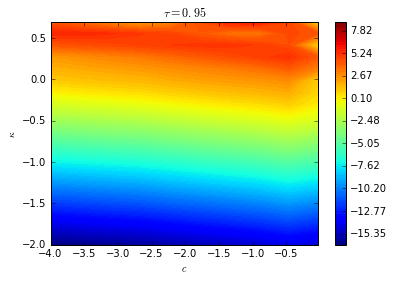

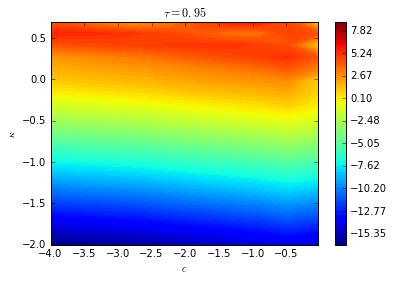

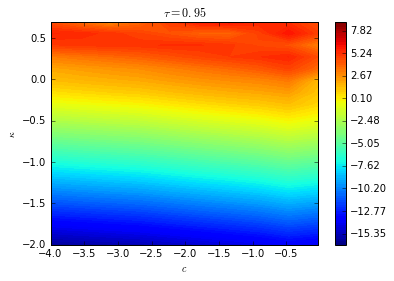

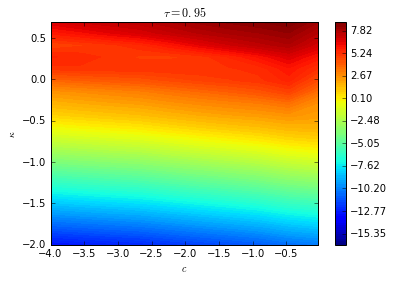

In [19]:

# for i_kappa, kappa in enumerate(kappa_values):
#     ir_power = log_ir_amplitudes[i_kappa, :, :]
#     plt.figure()
#     plt.contourf(c_log, tau_log, ir_power, contours)
#     plt.title(r"$\kappa = {}$".format(kappa))
#     plt.ylabel(r"$c$")
#     plt.xlabel(r"$\tau$")
#     plt.colorbar()




# for i_tau, tau in enumerate(tau_values):
#     ir_power = log_ir_amplitudes[:, i_tau, :]
#     plt.figure()
#     plt.contourf(c_log, kappa_log, ir_power, contours)
#     plt.title(r"$\tau = {}$".format(tau))
#     plt.ylabel(r"$\kappa$")
#     plt.xlabel(r"$c$")
#     plt.colorbar()
    


for i_c, c in enumerate(c_values):
    ir_power = log_ir_amplitudes[:, :, i_c]
    plt.figure()
    plt.contourf(tau_log, kappa_log, ir_power, contours)
    plt.title(r"$\tau = {}$".format(tau))
    plt.ylabel(r"$\kappa$")
    plt.xlabel(r"$c$")
    plt.colorbar()
    


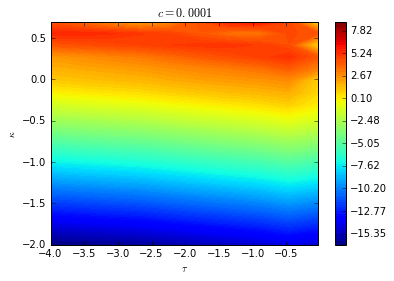

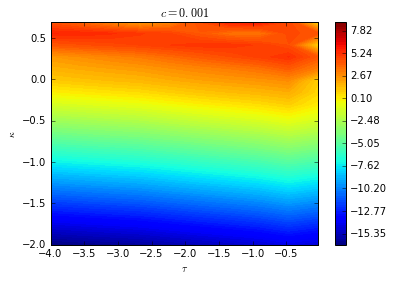

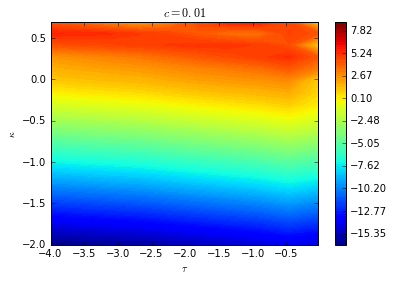

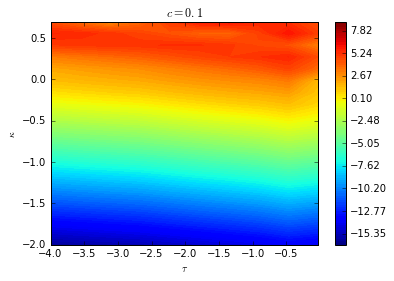

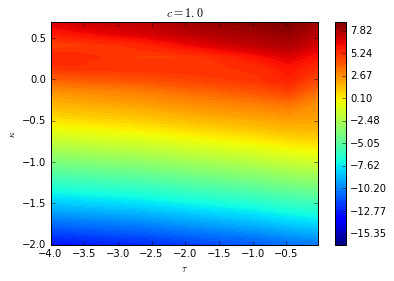

In [20]:
for i_c, c in enumerate(c_values):
    ir_power = log_ir_amplitudes[:, :, i_c]
    plt.figure()
    plt.contourf(tau_log, kappa_log, ir_power, contours)
    plt.title(r"$c = {}$".format(c))
    plt.ylabel(r"$\kappa$")
    plt.xlabel(r"$\tau$")
    plt.colorbar()
    plt.savefig("{}_expProtocol.png".format(c))

In [ ]:
np.linspace()